In [476]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
from geopy import distance

In [379]:
df = pd.read_csv("all_cleaned.csv")
df.head(10)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,954144C2F67B1932,classic_bike,2022-07-05 08:12:47,2022-07-05 08:24:32,Ashland Ave & Blackhawk St,13224,Kingsbury St & Kinzie St,KA1503000043,41.907066,-87.667252,41.889177,-87.638506,member
1,292E027607D218B6,classic_bike,2022-07-26 12:53:38,2022-07-26 12:55:31,Buckingham Fountain (Temp),A15541-1,Michigan Ave & 8th St,A623-1,41.869621,-87.623981,41.872773,-87.623981,casual
2,57765852588AD6E0,classic_bike,2022-07-03 13:58:49,2022-07-03 14:06:32,Buckingham Fountain (Temp),A15541-1,Michigan Ave & 8th St,A623-1,41.869621,-87.623981,41.872773,-87.623981,casual
3,B5B6BE44314590E6,classic_bike,2022-07-31 17:44:21,2022-07-31 18:42:50,Buckingham Fountain (Temp),A15541-1,Woodlawn Ave & 55th St,TA1307000164,41.869621,-87.623981,41.795264,-87.596471,casual
4,A4C331F2A00E79E0,classic_bike,2022-07-13 19:49:06,2022-07-13 20:15:24,Wabash Ave & Grand Ave,TA1307000117,Sheffield Ave & Wellington Ave,TA1307000052,41.891466,-87.626761,41.936253,-87.652662,member
5,579D73BE2ED880B3,electric_bike,2022-07-01 17:04:35,2022-07-01 17:13:18,Desplaines St & Randolph St,15535,Clinton St & Roosevelt Rd,WL-008,41.884614,-87.644564,41.867118,-87.641088,member
6,EFE518CCEE333669,classic_bike,2022-07-18 18:11:01,2022-07-18 18:22:30,Marquette Ave & 89th St,20239,East End Ave & 87th St,20231,41.733669,-87.558342,41.736815,-87.582801,member
7,315FEBB7B3F6D2EA,classic_bike,2022-07-28 20:38:18,2022-07-28 21:09:11,Wabash Ave & Grand Ave,TA1307000117,Dearborn Pkwy & Delaware Pl,TA1307000128,41.891466,-87.626761,41.898969,-87.629912,casual
8,EE3C4A1E66766B56,classic_bike,2022-07-10 22:55:59,2022-07-10 23:01:32,Wabash Ave & Grand Ave,TA1307000117,Dearborn Pkwy & Delaware Pl,TA1307000128,41.891466,-87.626761,41.898969,-87.629912,member
9,1EE6C93A547A187C,electric_bike,2022-07-10 09:35:58,2022-07-10 09:47:25,Ashland Ave & Blackhawk St,13224,Orleans St & Merchandise Mart Plaza,TA1305000022,41.907093,-87.667247,41.888243,-87.636390,member


In [380]:
len(df)

5779444

# Add columns for further use

## Ride distance

In [384]:
def calculate_distance(x):
    try:
        return distance.distance((x['start_lat'], x['start_lng']), (x['end_lat'], x['end_lng'])).km
    except ValueError:
        return np.nan
    
        
df['distance'] = df.apply(lambda x: calculate_distance(x), axis=1)

## The length of the ride

In [382]:
df["started_at"] = pd.to_datetime(df["started_at"], errors='coerce')
df["ended_at"] = pd.to_datetime(df["ended_at"], errors='coerce')
df['ride_length'] = (df["ended_at"] - df["started_at"]).dt.total_seconds() / 60

5779444

## Check if it is a work day

In [383]:
national_holidays = [
    '2022-07-04',  # Independence Day
    '2022-09-05',  # Labor Day
    '2022-10-10',  # Columbus Day
    '2022-11-11',  # Veterans Day
    '2022-11-24',  # Thanksgiving Day
    '2022-12-25',  # Christmas Day
    '2023-01-01',  # New Year's Day
    '2023-01-16',  # Martin Luther King Jr. Day
    '2023-02-20',  # Presidents' Day
    '2023-05-29'   # Memorial Day
    ] 

df['day_of_week'] = df["started_at"].dt.dayofweek
df['is_holiday'] = df["started_at"].isin(national_holidays)
df['work_day'] = 1 - (df['is_holiday'] | (df['day_of_week'].isin([5, 6]))).astype(int) # 1 is work day and 0 is non work day


5779444

## Check if it is rush_hour

In [385]:
df['rush_hour'] =  (((df['started_at'].dt.hour >= 7) & (df['started_at'].dt.hour <= 9)) | \
                             ((df['started_at'].dt.hour >= 16) & (df['started_at'].dt.hour <= 18)) & df['work_day']).astype(int) # 1 is rush hour and 0 is non rush hour

# Calculate the speed

In [386]:
df['speed'] = df['distance'].div(df['ride_length'])

# Turn the ride length into three categories
0-30 min = very short trip \
30-60 min = short trip \
60-120 = medium trip \
\>120 = long trip 

In [387]:
df['ride_length_category'] = pd.cut(df['ride_length'], [0, 30, 60, 120, float('inf')])

# Analyze data

## Overview

In [388]:
df.groupby('member_casual').agg({'distance': ['mean', 'median'], 'work_day': ['count']})

distance           work_day
                   mean    median    count
member_casual                             
casual         2.134677  1.612688  2244252
member         2.105076  1.505767  3535192

## Work day

In [389]:
work_day = df.groupby(['work_day', 'member_casual']).size() / df.groupby('work_day').size() * 100
work_day

work_day  member_casual
0         casual           48.769579
          member           51.230421
1         casual           34.814287
          member           65.185713
dtype: float64

(-0.5, 1.5, 0.0, 80.0)

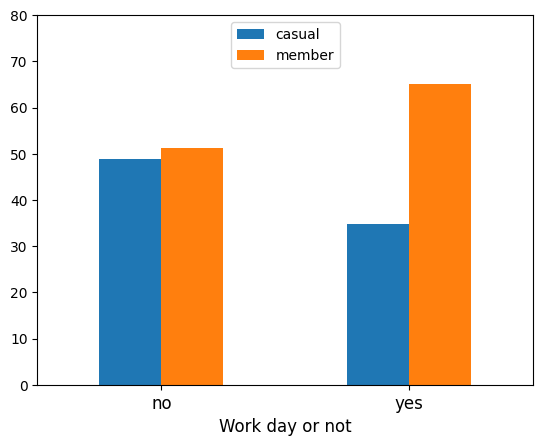

In [709]:
ax_work_day = work_day.unstack('member_casual').plot.bar()
ax_work_day.set_xlabel('Work day or not', fontsize='large')
ax_work_day.set_xticklabels(["no","yes"], rotation=0, fontsize='large') 
ax_work_day.legend(loc=9)
ax_work_day.axis(ymax=80)

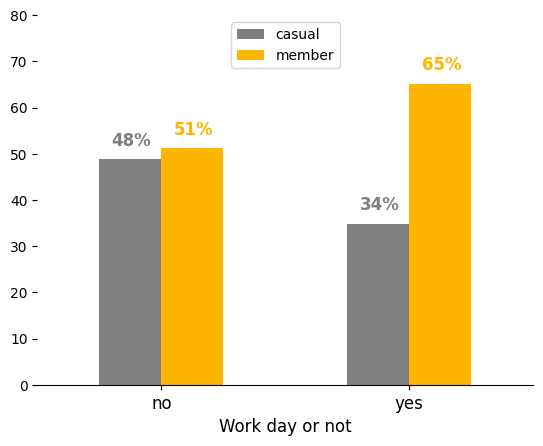

In [710]:
ax_work_day = work_day.unstack('member_casual').plot.bar(color=['grey', '#FFB400'])
ax_work_day.set_xlabel('Work day or not', fontsize='large')
ax_work_day.set_xticklabels(["no","yes"], rotation=0, fontsize='large') 
ax_work_day.spines['top'].set_visible(False)
ax_work_day.spines['right'].set_visible(False)
ax_work_day.spines['left'].set_visible(False)

ax_work_day.legend(loc=9)
ax_work_day.axis(ymax=80)
for i, v in enumerate(work_day):
    if i % 2 == 1:
        ax_work_day.text(int(i/2)+0.05, v+3, str(int(v))+'%', color='#FFB400', fontweight='bold', fontsize='large')
    else:
        ax_work_day.text(int(i/2)-0.2, v+3, str(int(v))+'%', color='grey', fontweight='bold', fontsize='large')


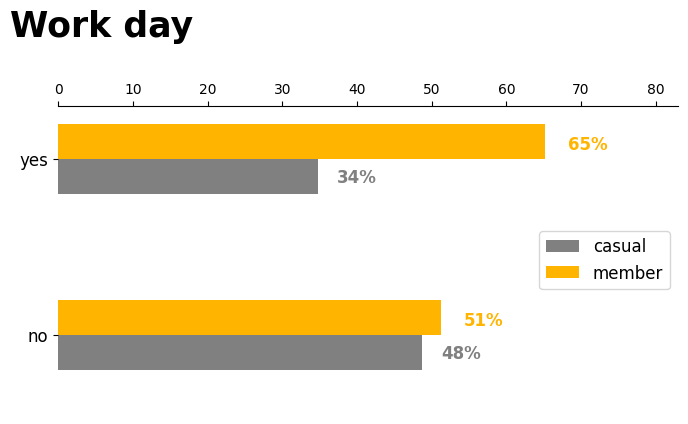

In [762]:
ax_work_day = work_day.unstack('member_casual').plot(figsize=(8, 4), kind='barh', color=['grey', '#FFB400'], width=0.4)
ax_work_day.set_title("Work day", fontweight='bold', fontsize=25, x=0.07, pad=50)
ax_work_day.set_ylabel('')
ax_work_day.set_yticklabels(['no', 'yes'], rotation=0, fontsize=12)
ax_work_day.xaxis.tick_top()

ax_work_day.spines['right'].set_visible(False)
ax_work_day.spines['left'].set_visible(False)
ax_work_day.spines['bottom'].set_visible(False)

ax_work_day.legend(loc=7, fontsize='large')
ax_work_day.axis(xmax=83, ymax=1.3)
for i, v in enumerate(work_day):
    if i % 2 == 1:
        ax_work_day.text(v+3, int(i/2)+0.05, str(int(v))+'%', color='#FFB400', fontweight='bold', fontsize='large')
    else:
        ax_work_day.text(v+2.5, int(i/2)-0.135, str(int(v))+'%', color='grey', fontweight='bold', fontsize='large')


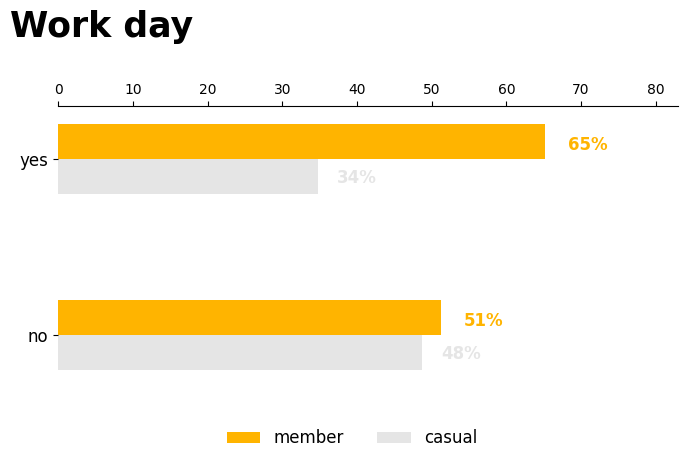

In [763]:
ax_work_day = work_day.unstack('member_casual').plot(figsize=(8, 4), kind='barh', color=['grey', '#FFB400'], width=0.4)
for bars in ax_work_day.containers[0]:
    bars.set_alpha(0.2)
ax_work_day.set_title("Work day", fontweight='bold', fontsize=25, x=0.07, pad=50)
ax_work_day.set_ylabel('')
ax_work_day.set_yticklabels(['no', 'yes'], rotation=0, fontsize=12)
ax_work_day.xaxis.tick_top()

ax_work_day.spines['right'].set_visible(False)
ax_work_day.spines['left'].set_visible(False)
ax_work_day.spines['bottom'].set_visible(False)

ax_work_day.axis(xmax=83, ymax=1.3)

handles, labels = ax_work_day.get_legend_handles_labels()
handles.reverse()
labels.reverse()
ax_work_day.legend(handles, labels, loc=0, fontsize='large', frameon=False, bbox_to_anchor=(0.7, 0), ncol=2)
for i, v in enumerate(work_day):
    if i % 2 == 1:
        ax_work_day.text(v+3, int(i/2)+0.05, str(int(v))+'%', color='#FFB400', fontweight='bold', fontsize='large')
    else:
        ax_work_day.text(v+2.5, int(i/2)-0.135, str(int(v))+'%', color='grey', fontweight='bold', fontsize='large', alpha=0.2)


## Observation
On week days, more members use the service than on non-work days
## Assumption
Members use divvy bike to commute

## Rush hour

In [394]:
rush_hour = df.groupby(['rush_hour', 'member_casual']).size() / df.groupby('rush_hour').size() * 100
rush_hour

rush_hour  member_casual
0          casual           42.855196
           member           57.144804
1          casual           31.142981
           member           68.857019
dtype: float64

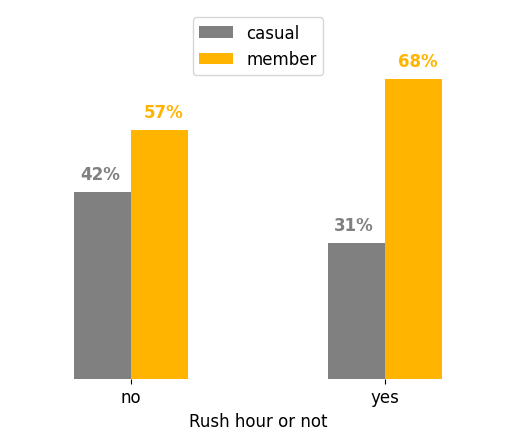

In [713]:
ax_rush_hour = rush_hour.unstack('member_casual').plot.bar(color=['grey', '#FFB400'], width=0.45)
ax_rush_hour.set_xlabel('Rush hour or not', fontsize='large')
ax_rush_hour.set_xticklabels(['no', 'yes'], rotation=0, fontsize='large')
ax_rush_hour.get_yaxis().set_visible(False)
ax_rush_hour.spines['top'].set_visible(False)
ax_rush_hour.spines['right'].set_visible(False)
ax_rush_hour.spines['left'].set_visible(False)
ax_rush_hour.spines['bottom'].set_visible(False)
ax_rush_hour.legend(loc=9, fontsize='large')
ax_rush_hour.axis(ymax=85)
for i, v in enumerate(rush_hour):
    if i % 2 == 1:
        ax_rush_hour.text(int(i/2)+0.05, v+3, str(int(v))+'%', color='#FFB400', fontweight='bold', fontsize='large')
    else:
        ax_rush_hour.text(int(i/2)-0.2, v+3, str(int(v))+'%', color='grey', fontweight='bold', fontsize='large')



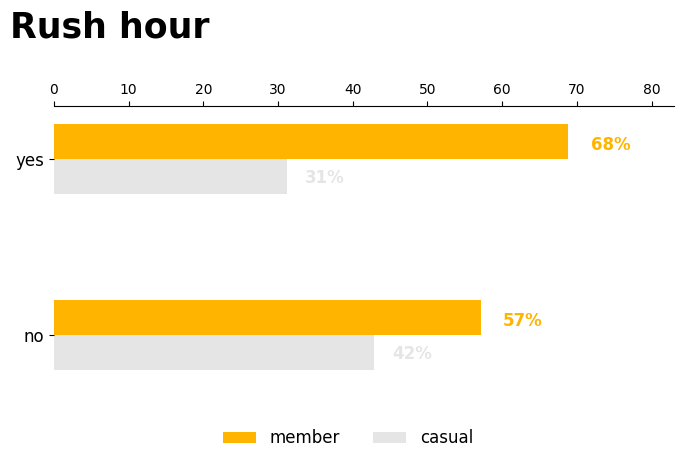

In [759]:
ax_rush_hour = rush_hour.unstack('member_casual').plot(figsize=(8, 4), kind='barh', color=['grey', '#FFB400'], width=0.4)
for bars in ax_rush_hour.containers[0]:
    bars.set_alpha(0.2)
ax_rush_hour.set_title("Rush hour", fontweight='bold', fontsize=25, x=0.09, pad=50)
# ax.set_ylabel('Rush hour\n or not', fontsize=14, rotation=0, labelpad=30)
ax_rush_hour.set_ylabel('')
ax_rush_hour.set_yticklabels(['no', 'yes'], rotation=0, fontsize=12)
ax_rush_hour.xaxis.tick_top()
# ax.get_xaxis().set_visible(False)
# ax.spines['top'].set_visible(False)
ax_rush_hour.spines['right'].set_visible(False)
ax_rush_hour.spines['left'].set_visible(False)
ax_rush_hour.spines['bottom'].set_visible(False)

handles, labels = ax_rush_hour.get_legend_handles_labels()
handles.reverse()
labels.reverse()
ax_rush_hour.legend(handles, labels, loc=0, fontsize='large', frameon=False, bbox_to_anchor=(0.7, 0), ncol=2)

ax_rush_hour.axis(xmax=83, ymax=1.3)
for i, v in enumerate(rush_hour):
    if i % 2 == 1:
        ax_rush_hour.text(v+3, int(i/2)+0.05, str(int(v))+'%', color='#FFB400', fontweight='bold', fontsize='large')
    else:
        ax_rush_hour.text(v+2.5, int(i/2)-0.135, str(int(v))+'%', color='grey', fontweight='bold', fontsize='large', alpha=0.2)



## Ride length

In [397]:
df.groupby('member_casual').agg({'ride_length': ['mean', 'median']})

ride_length       
                     mean median
member_casual                   
casual          27.729068  12.00
member          12.379864   8.55

In [661]:
ride_length_category = df.groupby(['ride_length_category', 'member_casual']).size() / df.groupby('ride_length_category').size() * 100
ride_length_category

ride_length_category  member_casual
(0.0, 30.0]           casual           36.004712
                      member           63.995288
(30.0, 60.0]          casual           57.685356
                      member           42.314644
(60.0, 120.0]         casual           84.348072
                      member           15.651928
(120.0, inf]          casual           81.210129
                      member           18.789871
dtype: float64

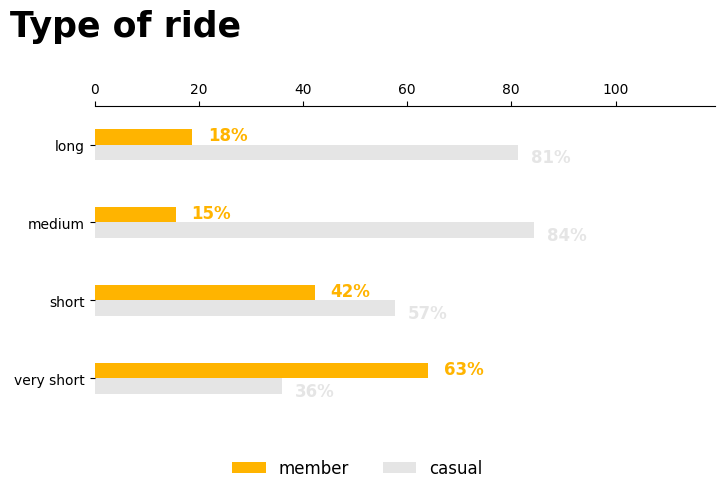

In [756]:
ax_ride_length_category = ride_length_category.unstack('member_casual').plot(figsize=(8, 4), kind='barh', color=['grey', '#FFB400'], width=0.4)
for bars in ax_ride_length_category.containers[0]:
    bars.set_alpha(0.2)
ax_ride_length_category.set_title("Type of ride", fontweight='bold', fontsize=25, x=0.05, pad=50)
ax_ride_length_category.set_ylabel('')
ax_ride_length_category.set_yticklabels(['very short', 'short', 'medium', 'long'], rotation=0)
ax_ride_length_category.xaxis.tick_top()

ax_ride_length_category.spines['bottom'].set_visible(False)
ax_ride_length_category.spines['right'].set_visible(False)
ax_ride_length_category.spines['left'].set_visible(False)

ax_ride_length_category.axis(xmax=119, ymax=3.5)
ax_ride_length_category.get_legend().remove()

handles, labels = ax_ride_length_category.get_legend_handles_labels()
handles.reverse()
labels.reverse()
ax_ride_length_category.legend(handles, labels, loc=0, fontsize='large', frameon=False, bbox_to_anchor=(0.65, -0.1), ncol=2)

for i, v in enumerate(ride_length_category):
    if i % 2 == 1:
        ax_ride_length_category.text(v+3, int(i/2)+0.06, str(int(v))+'%', color='#FFB400', fontweight='bold', fontsize='large')
    else:
        ax_ride_length_category.text(v+2.5, int(i/2)-0.23, str(int(v))+'%', color='grey', fontweight='bold', fontsize='large', alpha=0.2)


In [377]:
df.groupby([df['started_at'].dt.month, 'member_casual']).size()

started_at  member_casual
7           casual           406055
            member           417433
8           casual           305105
            member           366249
dtype: int64

In [378]:
len(df)

1494842

In [79]:
df1['ride_duration'] = df1['ride_duration'].dt.total_seconds() / 60

In [80]:
df1.loc[0, 'ride_duration']

11.75

In [90]:
df.groupby('member_casual')['ride_duration'].mean()

member_casual
casual   0 days 00:29:16.685269236
member   0 days 00:13:43.100408927
Name: ride_duration, dtype: timedelta64[ns]

In [145]:
result = df.groupby('start_station_id')['member_casual'].agg(
    Count='size',
    Percentage_Member=lambda x: (x == 'member').sum() / len(x) * 100
)
result_drop_no_use = result[result['Count']>=150]

In [174]:
stations_most_used = result_drop_no_use.sort_values(by='Count', ascending=False)[:100]
stations_most_used_by_member = result_drop_no_use.sort_values(by='Percentage_Member', ascending=False)[:100]

In [165]:
stations_most_used_by_member.sort_values(by='Count')

,Count,Percentage_Member
start_station_id,,
KA1503000075,152,58.552632
314,154,38.311688
312,156,67.948718
15470,159,48.427673
432,159,32.075472
...,...,...
TA1308000001,6988,39.324556
13300,7833,21.434955
13042,7975,30.934169


In [166]:
stations_most_used

,Count,Percentage_Member
start_station_id,,
13022,14808,20.353863
LF-005,8753,36.318976
13042,7975,30.934169
13300,7833,21.434955
TA1308000001,6988,39.324556
...,...,...
432,159,32.075472
15470,159,48.427673
312,156,67.948718


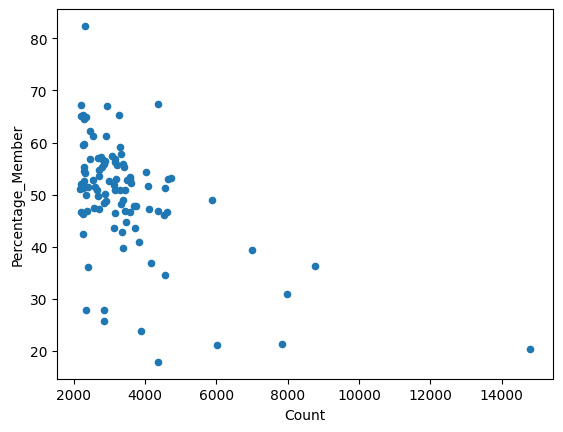

In [175]:
ax = stations_most_used.plot.scatter('Count', 'Percentage_Member')


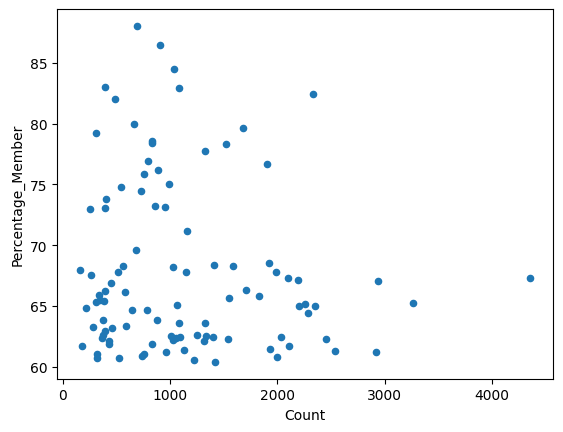

In [176]:
ax1 = stations_most_used_by_member.plot.scatter('Count', 'Percentage_Member')

In [177]:
len(stations_most_used_by_member.index.intersection(stations_most_used.index))

12